**Load and preprocess the data--Iris dataset**

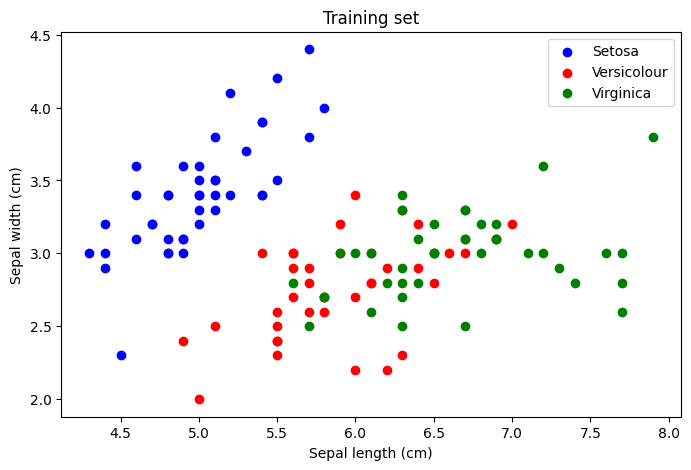

In [23]:
# Import stuff we will be needing
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import datasets, model_selection

# Load the dataset
iris = datasets.load_iris()

# Use only the first two features: sepal length and width
data = iris.data[:, :2]
targets = iris.target

# Randomly shuffle the data and make train and test splits
x_train, x_test, y_train, y_test = \
    model_selection.train_test_split(data, targets, test_size=0.2)

# Plot the training data
labels = {0: 'Setosa', 1: 'Versicolour', 2: 'Virginica'}
label_colours = ['blue', 'red', 'green']

def plot_data(x, y, labels, colours):
    for y_class in np.unique(y):
        index = np.where(y == y_class)
        plt.scatter(x[index, 0], x[index, 1],
                    label=labels[y_class], c=colours[y_class])
    plt.title("Training set")
    plt.xlabel("Sepal length (cm)")
    plt.ylabel("Sepal width (cm)")
    plt.legend()

plt.figure(figsize=(8, 5))
plot_data(x_train, y_train, labels, label_colours)
plt.show()

Construct the custom training loop
This code block is probably the single most important of the classifier. Here, we create trainable Gaussian distributions for the data set’s features with *tfd.MultivariateNormalDiag()*. The distributions’ parameters will be estimated by minimizing the negative log-likelihood, which is equivalent to maximizing the log-likelihood.

In [24]:
def learn_parameters(x, y, mus, scales, optimiser, epochs):
    """
    Set up the class conditional distributions as a MultivariateNormalDiag
    object, and update the trainable variables in a custom training loop.
    """
    @tf.function
    def nll(dist, x_train, y_train):
        log_probs = dist.log_prob(x_train)
        L = len(tf.unique(y_train)[0])
        y_train = tf.one_hot(indices=y_train, depth=L)
        return -tf.reduce_mean(log_probs * y_train)

    @tf.function
    def get_loss_and_grads(dist, x_train, y_train):
        with tf.GradientTape() as tape:
            tape.watch(dist.trainable_variables)
            loss = nll(dist, x_train, y_train)
            grads = tape.gradient(loss, dist.trainable_variables)
        return loss, grads

    nll_loss = []
    mu_values = []
    scales_values = []
    x = tf.cast(np.expand_dims(x, axis=1), tf.float32)
    dist = tfd.MultivariateNormalDiag(loc=mus, scale_diag=scales)
    for epoch in range(epochs):
        loss, grads = get_loss_and_grads(dist, x, y)
        optimiser.apply_gradients(zip(grads, dist.trainable_variables))
        nll_loss.append(loss)
        mu_values.append(mus.numpy())
        scales_values.append(scales.numpy())
    nll_loss, mu_values, scales_values = \
        np.array(nll_loss), np.array(mu_values), np.array(scales_values)
    return (nll_loss, mu_values, scales_values, dist)

Train the model.  
Next, we assign some initial values to the model’s parameters, instantiate an Adam optimizer, and call the learn_parameters() function to actually perform the training.

In [25]:
# Assign initial values for the model's parameters
mus = tf.Variable([[1., 1.], [1., 1.], [1., 1.]])
scales = tf.Variable([[1., 1.], [1., 1.], [1., 1.]])
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
epochs = 10000
nlls, mu_arr, scales_arr, class_conditionals = \
    learn_parameters(x_train, y_train, mus, scales, opt, epochs)

After the training has been completed, we plot the loss vs. epoch to ensure that our optimizer converged. We also plot for the same reasons the values of our model’s parameters.

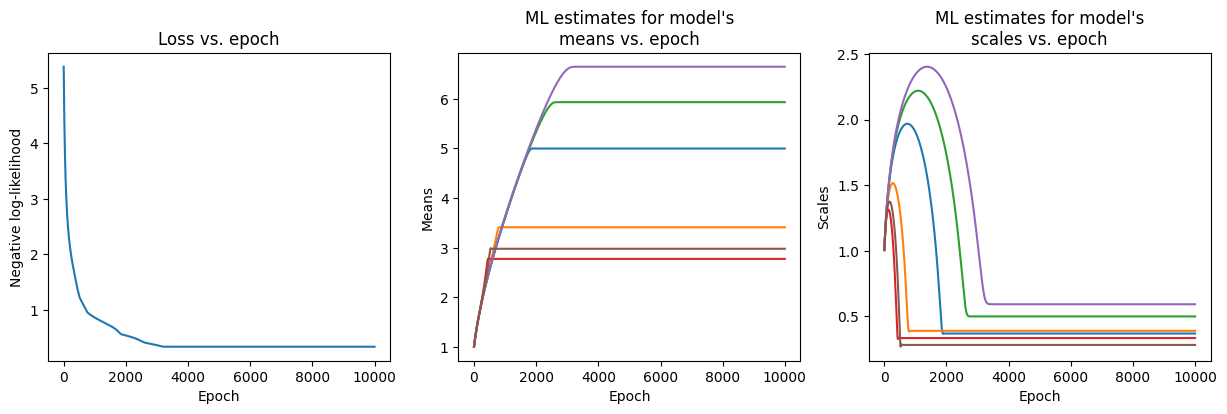

In [26]:
# Plot the loss and convergence of the standard deviation parameters
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(nlls)
ax[0].set_title("Loss vs. epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Negative log-likelihood")
for k in [0, 1, 2]:
    ax[1].plot(mu_arr[:, k, 0])
    ax[1].plot(mu_arr[:, k, 1])
ax[1].set_title("ML estimates for model's\nmeans vs. epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Means")
for k in [0, 1, 2]:
    ax[2].plot(scales_arr[:, k, 0])
    ax[2].plot(scales_arr[:, k, 1])
ax[2].set_title("ML estimates for model's\nscales vs. epoch")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Scales")
plt.show()

Indeed, our training loop achieved convergence, and the model’s parameters settled on their best estimates, even if they all started with the same initial conditions. The following code plots the three bivariate Gaussian distributions for the three classes.

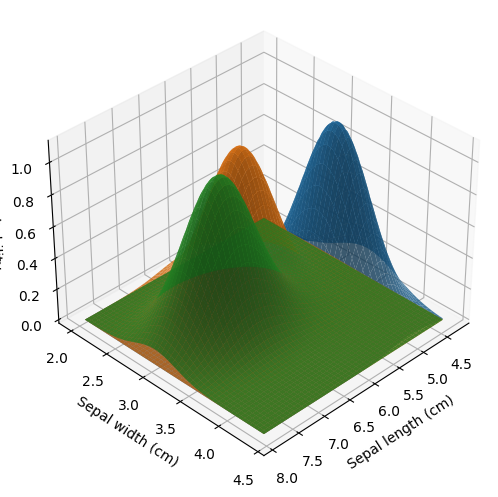

In [27]:
def get_meshgrid(x0_range, x1_range, n_points=100):
    x0 = np.linspace(x0_range[0], x0_range[1], n_points)
    x1 = np.linspace(x1_range[0], x1_range[1], n_points)
    return np.meshgrid(x0, x1)

x0_range = x_train[:, 0].min(), x_train[:, 0].max()
x1_range = x_train[:, 1].min(), x_train[:, 1].max()
X0, X1 = get_meshgrid(x0_range, x1_range, n_points=300)
X_v = np.expand_dims(np.array([X0.ravel(), X1.ravel()]).T, axis=1)
Z = class_conditionals.prob(X_v)
Z = np.array(Z).T.reshape(3, *X0.shape)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(projection='3d')
for k in [0,1,2]:
    ax.plot_surface(X0, X1, Z[k,:,:], alpha=.8)
ax.set_xlabel('Sepal length (cm)')
ax.set_ylabel('Sepal width (cm)')
ax.set_zlabel('Probability');
ax.elev = 35
ax.azim = 45

We may also print the model’s parameters:

In [28]:
# View the distribution parameters
print("Class conditional means:")
print(class_conditionals.loc.numpy())
print("\nClass conditional standard deviations:")
print(class_conditionals.stddev().numpy())
# Class conditional means:
# [[5.002439  3.42439  ]
# [5.89      2.78     ]
# [6.5179486 2.9307692]]

# Class conditional standard deviations:
# [[0.34675348 0.37855995]
# [0.5309426  0.31796226]
# [0.5808357  0.28025055]]

Class conditional means:
[[4.9952383 3.409524 ]
 [5.9289474 2.773684 ]
 [6.6425    2.9774997]]

Class conditional standard deviations:
[[0.36836344 0.38902166]
 [0.4988977  0.3337855 ]
 [0.5915605  0.28150228]]


Measure model’s accuracy
To measure the model’s accuracy, we need to be able to make some predictions, which in turn means that we must be able to calculate:
$C_{predicted}=argmax_{ck∈CP}(C-{k}k)∏_{i=1...n}P(x_{i}|C_{k})$

Up until now, we have calculated the feature distributions $P(x_{i}∣C_{k})$
, which is the hardest part. We will now estimate the priors as the relative frequencies of each class in the data set.

In [29]:
def get_prior(y):
    """
    This function takes training labels as a numpy array y of shape (num_samples,) as an input,
    and builds a Categorical Distribution object with empty batch shape and event shape,
    with the probability of each class.
    """
    counts = np.bincount(y)
    dist = tfd.Categorical(probs=counts/len(y))
    return dist

prior = get_prior(y_train)
prior.probs

#    <tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.34166667, 0.33333333, 0.325     ])>

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.35      , 0.31666667, 0.33333333])>

Since we have 3 classes in the data set, we calculated 3 priors: $P(C_{1})=0.342,P(C_{2})=0.333
, and P(C_{3})=0.325$
. Next, we will setup a predict_class(), that will act as the arg max
 opetator.

In [30]:
def predict_class(prior, class_conditionals, x):
    def predict_fn(myx):
        class_probs = class_conditionals.prob(tf.cast(myx, dtype=tf.float32))
        prior_probs = tf.cast(prior.probs, dtype=tf.float32)
        class_times_prior_probs = class_probs * prior_probs
        Q = tf.reduce_sum(class_times_prior_probs)       # Technically, this step
        P = tf.math.divide(class_times_prior_probs, Q)   # and this one, are not necessary.
        Y = tf.cast(tf.argmax(P), dtype=tf.float64)
        return Y
    y = tf.map_fn(predict_fn, x)
    return y

# Get the class predictions
# Evaluate the model accuracy on the test set
predictions = predict_class(prior, class_conditionals, x_test)
accuracy = accuracy_score(y_test, predictions)
print("Test accuracy: {:.4f}".format(accuracy))

#    Test accuracy: 0.8667

Test accuracy: 0.7667


So, our model achieved an accuracy of 0.8667 on the test set, which is pretty good, considering that we used only 2 out of the 4 features of the dataset!

Plot the decision regions
In a classification problem with N
 classes, a decision boundary is a hypersurface partitioning the feature space into N
 sets, one for each class. All the points on the same side of the decision boundary are taken to belong to the same category. In our case, we had 2 features and 3 classes; therefore, the classifier partitions the 2D plane into 3 regions. The decision boundary is the area where the predicted label becomes ambiguous.

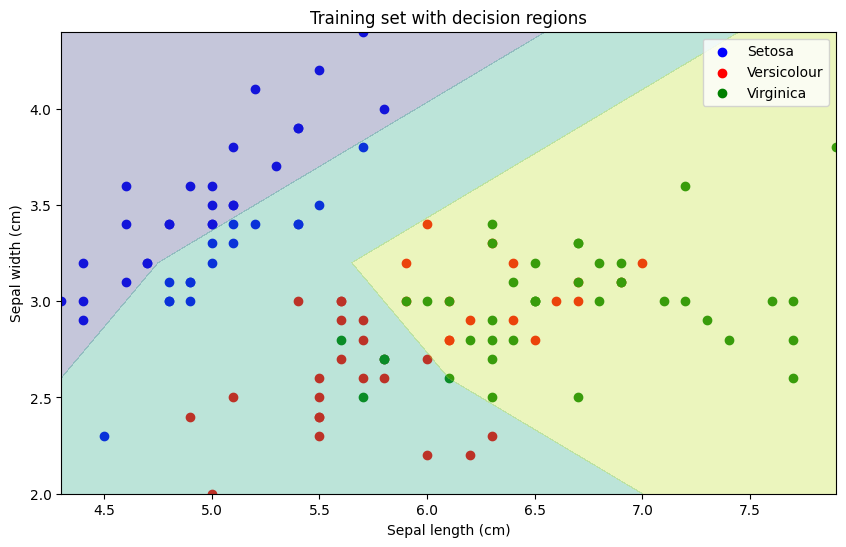

In [31]:
def contour_plot(x0_range, x1_range, prob_fn, batch_shape, levels=None, n_points=100):
    X0, X1 = get_meshgrid(x0_range, x1_range, n_points=n_points)
    # X0.shape = (100, 100)
    # X1.shape = (100, 100)
    X_values = np.expand_dims(np.array([X0.ravel(), X1.ravel()]).T, axis=1)
    # X_values.shape = (1000, 1, 2)
    Z = prob_fn(X_values)
    # Z.shape = (10000, 3)
    Z = np.array(Z).T.reshape(batch_shape, *X0.shape)
    # Z.shape = (3, 100, 100)
    for batch in np.arange(batch_shape):
        plt.contourf(X0, X1, Z[batch], alpha=0.3, levels=levels)

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels=labels, colours=label_colours)
contour_plot(x0_range, x1_range,
             lambda x: predict_class(prior, class_conditionals, x),
             1, n_points=3, levels=[-0.5, 0.5, 1.5, 2])
plt.title("Training set with decision regions")
plt.show()

A note regarding Gaussian distributions
When the feature distributions are Gaussian, there exist analytic solutions for the distributions’ parameters:
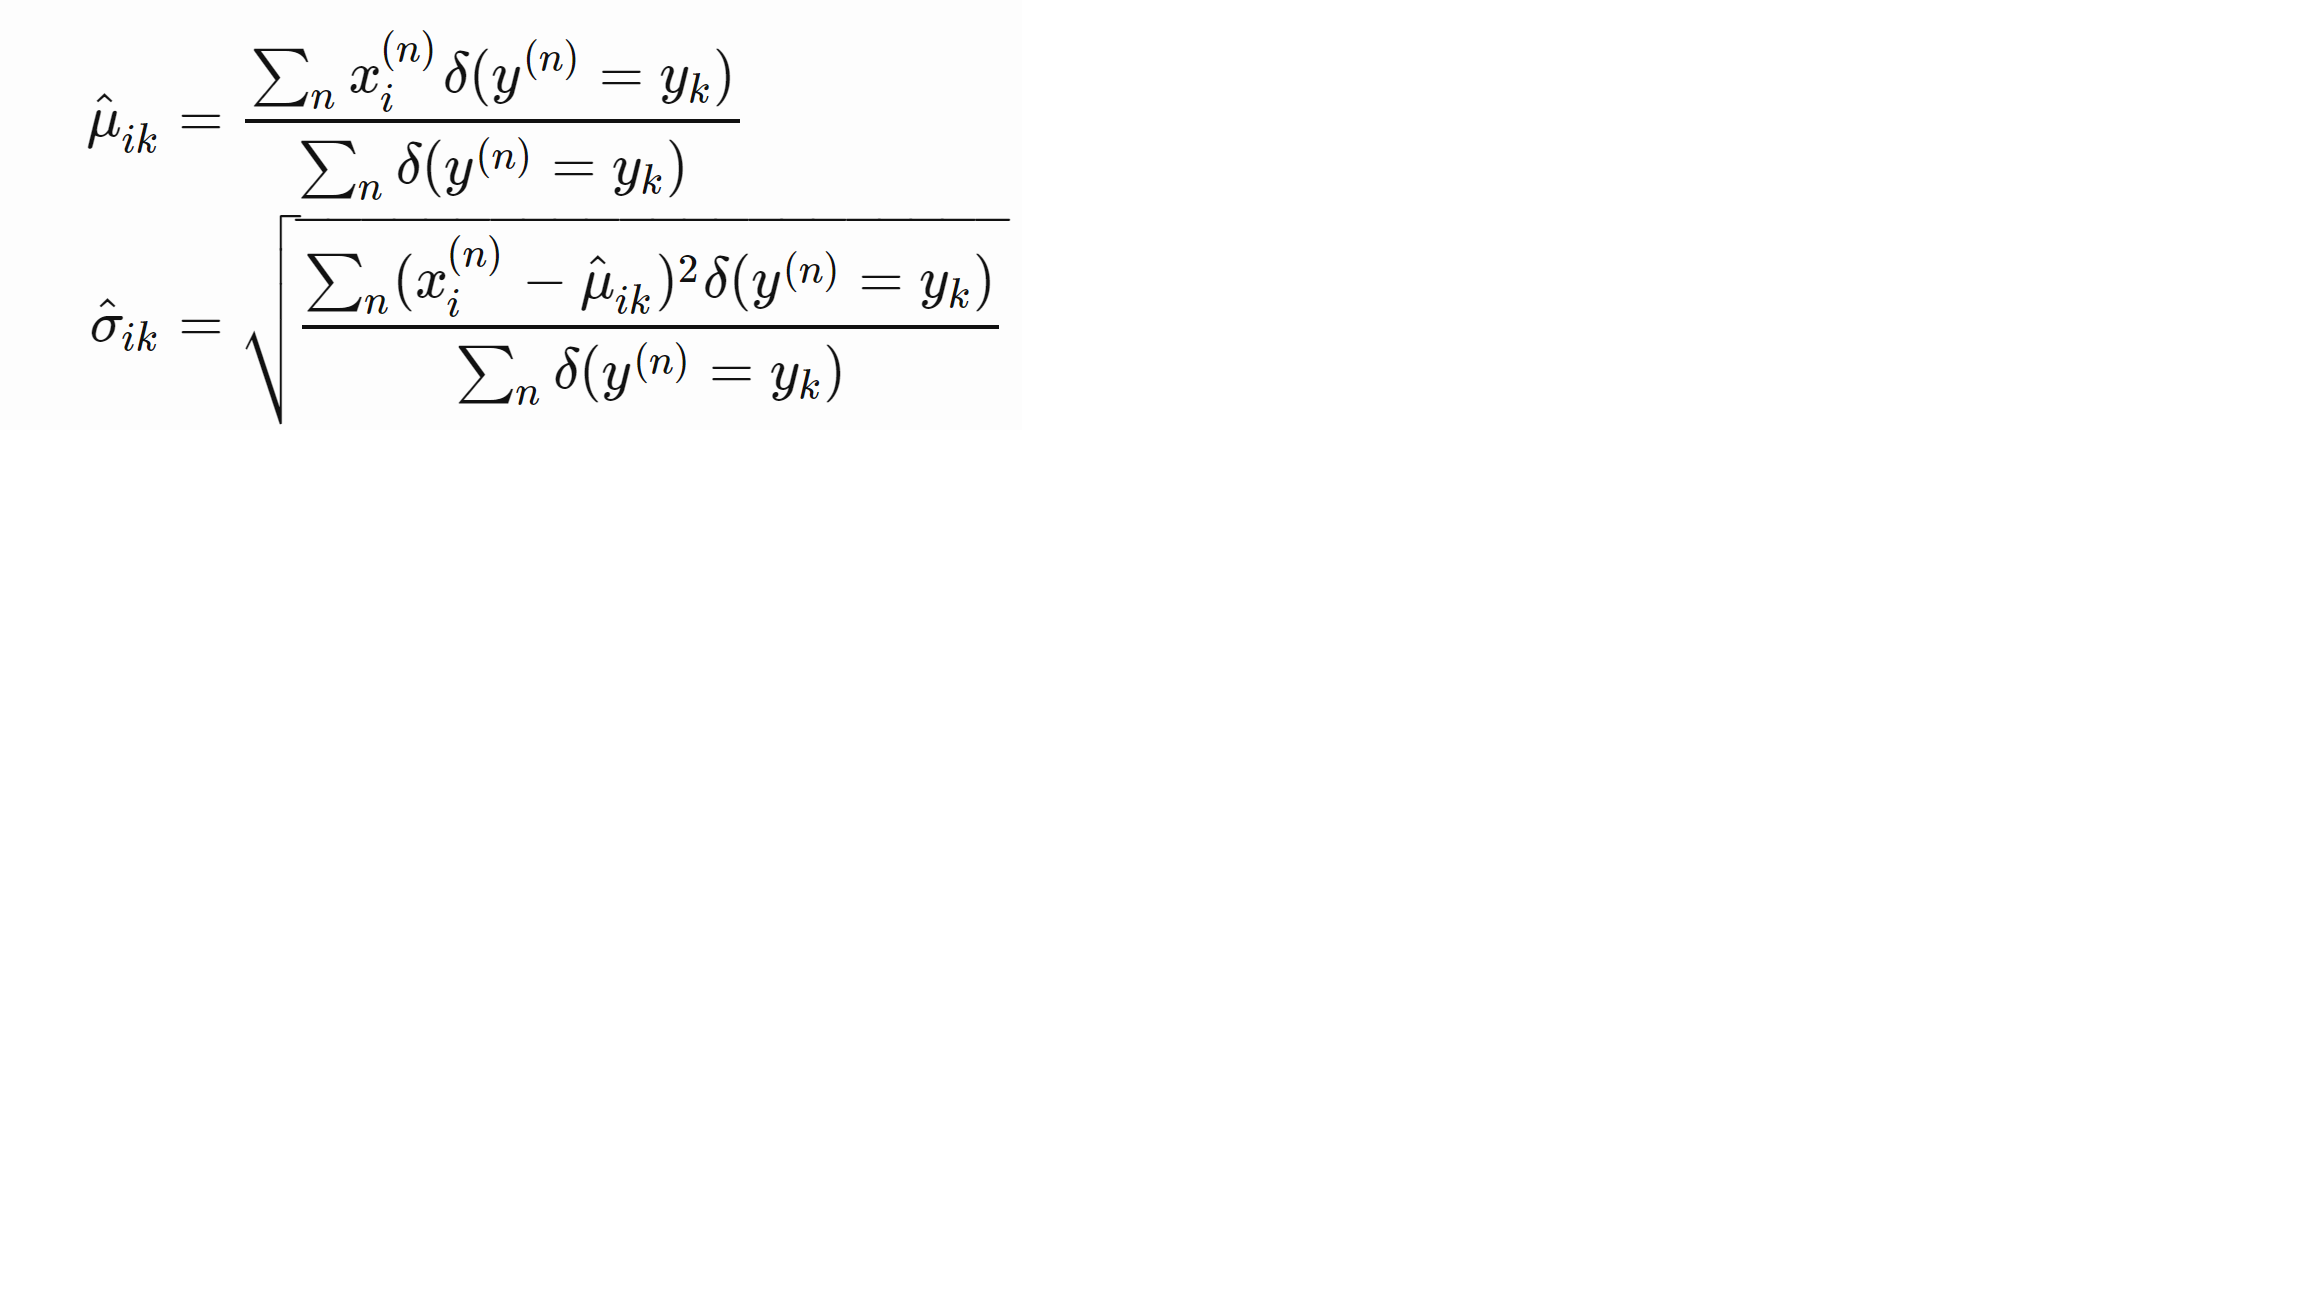
Where the superscript (n)
 denotes the n
-th example of the data set, $δ(y^{(n)}=y_{k})=1$
 if $y^{(n)}=y_{k}$
 and 0 otherwise, and N
 is the total number of examples. Note that the above are just the means and standard deviations of the sample data points for each class.

In [32]:
def get_analytic_optimal_class_conditionals(x, y):
    """
    This function takes training data samples x and labels y as inputs,
    and builds the class conditional Gaussian distributions based on
    analytic solutions for optimal parameters.
    """
    def delta(a, b):
        return 1. if a == b else 0.

    n_samples = len(y)
    mu = []
    sigma = []
    for k in range(3): # Loop over every class
        inner_mu = []
        inner_sigma = []
        for i in range(2): # Loop over every feature
            dyk = [delta(y[r], k) for r in range(n_samples)]
            xin = x[:, i]
            mu_ik = np.dot(xin, dyk) / np.sum(dyk)
            sigma_squared_ik = np.dot((xin - mu_ik)**2, dyk) / np.sum(dyk)
            inner_mu.append(mu_ik)
            inner_sigma.append(np.sqrt(sigma_squared_ik))
        mu.append(inner_mu)
        sigma.append(inner_sigma)
    dist = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    return dist

class_conditionals = get_analytic_optimal_class_conditionals(x_train, y_train)
class_conditionals.loc, class_conditionals.stddev()

# (<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
#  array([[5.00930233, 3.41860465],
#         [5.91081081, 2.78108108],
#         [6.635     , 2.975     ]])>,
#  <tf.Tensor: shape=(3, 2), dtype=float64, numpy=
#  array([[0.32694068, 0.37926233],
#         [0.53966145, 0.32201883],
#         [0.68758636, 0.34332929]])>)

(<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
 array([[4.9952381 , 3.40952381],
        [5.92894737, 2.77368421],
        [6.6425    , 2.9775    ]])>,
 <tf.Tensor: shape=(3, 2), dtype=float64, numpy=
 array([[0.36836342, 0.38902168],
        [0.49889768, 0.33378547],
        [0.59156044, 0.28150266]])>)

Indeed, the values we got via maximum likelihood estimation are pretty close to the values derived from the analytic solutions!

Pros and cons of naive Bayes classifier  
  
Advantages of naive Bayes classifier:  
Works quite well in real-world applications.
Requires only a small amount of training data.
With each training example, prior and likelihood can be updated in real-time.
Since it assumes independent variables, only the class variables’ variances need to be estimated and not the entire covariance matrix (i.e., fewer parameters to calculate).
Fast training and fast inference.
It gives a probability distribution over all classes (i.e., not just a classification).
Multiple classifiers may be combined, e.g., by taking the product of their predicted probabilities.
May be used as a first-line “punching bag” before other smarter algorithms kick in the problem.  
  
Disadvantages:

More sophisticated models outperform them.

Conclusion:  
  
By following this tutorial, I can grasp how a Naive Bayes Classifier works,  
from preproccesing,  
constructing the model,  
testing the model,  
and checking model accuracy.  
  
This tutorial goes through every step with great detail, even though this is only a fundamental Classifier for machine learning, it showed me how machine learning usually works, and where to customize in order to meet my needs (Processing speed, processing data amount et al.)